In [1]:
#!pip install chart-studio

In [1]:
from chart_studio import plotly

In [3]:
#!pip install cufflinks

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [4]:
data=pd.read_csv(r"C:\Users\SUBHESH KUMAR JHA\Desktop\Consumer_Complaints.csv")
data

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Complaint ID
0,17-01-2015,Credit card,NaN,Customer service / Customer relations,NaN,NaN,NaN,Citibank,TX,75241,NaN,NaN,Web,17-01-2015,Closed with monetary relief,Yes,1198133
1,22-06-2016,Consumer Loan,Title loan,Payment to acct not credited,NaN,NaN,Company believes it acted appropriately as aut...,"Larsen MacColl Partners II, L.P.",TX,76548,Servicemember,NaN,Phone,22-06-2016,Closed with explanation,Yes,1979989
2,04-09-2015,Credit card,NaN,Credit line increase/decrease,NaN,I WANT TO REQUEST A CREDIT LINE INCREASE OF XX...,NaN,Capital One,NC,271XX,NaN,Consent provided,Web,04-09-2015,Closed with explanation,Yes,1552090
3,17-05-2016,Consumer Loan,Installment loan,Problems when you are unable to pay,NaN,I have asked One Main Financial not to call my...,NaN,"OneMain Financial Holdings, LLC",MO,634XX,NaN,Consent provided,Web,20-05-2016,Closed with non-monetary relief,Yes,1929306
4,07-07-2016,Debt collection,"Other (i.e. phone, health club, etc.)",Improper contact or sharing of info,Contacted employer after asked not to,I have received several calls from a XXXX XXXX...,Company has responded to the consumer and the ...,"GMA Investments, LLC",SC,296XX,NaN,Consent provided,Web,07-07-2016,Closed with explanation,Yes,2001667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119601,09-02-2015,Credit card,NaN,Credit determination,NaN,NaN,NaN,Citibank,IL,60803,NaN,NaN,Web,09-02-2015,Closed with explanation,Yes,1230729
119602,13-11-2012,Credit card,NaN,Balance transfer,NaN,NaN,NaN,Capital One,KS,67114,NaN,NaN,Web,14-11-2012,Closed with explanation,Yes,189749
119603,15-05-2012,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Bank of America,CA,95691,NaN,NaN,Referral,15-05-2012,Closed without relief,Yes,78574
119604,07-06-2015,Credit reporting,NaN,Incorrect information on credit report,Reinserted previously deleted info,"In XX/XX/XXXX, a Collection firm by the name o...",Company chooses not to provide a public response,Experian,OH,436XX,NaN,Consent provided,Web,07-06-2015,Closed with explanation,Yes,1409765


In [5]:
data = data[["Product","Issue"]]
data=data.astype(str)

In [6]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
VERB_CODES = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}

[nltk_data] Downloading package stopwords to C:\Users\SUBHESH KUMAR
[nltk_data]     JHA\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [8]:
def preprocess_sentences(text):
    text = text.lower() #converts text into lower alphabets
    temp_sent =[]
    words = nltk.word_tokenize(text) #word tokenizer
    tags = nltk.pos_tag(words) #to mark up the words in text format for a particular part of a speech based on its definition.
    for i, word in enumerate(words):
        if tags[i][1] in VERB_CODES:
            lemmatized = lemmatizer.lemmatize(word, 'v') #Lemmatization in verb form for verb POS tagged words.
        else:
            lemmatized = lemmatizer.lemmatize(word)
        if lemmatized not in stop_words and lemmatized.isalpha(): #The isalpha() method returns True if all the characters are alphabet letters (a-z)
            temp_sent.append(lemmatized)

    finalsent = ' '.join(temp_sent)
    finalsent = finalsent.replace("n't", " not")
    finalsent = finalsent.replace("'m", " am")
    finalsent = finalsent.replace("'s", " is")
    finalsent = finalsent.replace("'re", " are")
    finalsent = finalsent.replace("'ll", " will")
    finalsent = finalsent.replace("'ve", " have")
    finalsent = finalsent.replace("'d", " would")
    finalsent = finalsent.replace("voc","")
    finalsent = finalsent.replace("oc","")
    
    return finalsent

data["Issue_processed"]= data["Issue"].apply(preprocess_sentences)
data.head()

,Product,Issue,Issue_processed
0,Credit card,Customer service / Customer relations,customer service customer relation
1,Consumer Loan,Payment to acct not credited,payment acct credit
2,Credit card,Credit line increase/decrease,credit line
3,Consumer Loan,Problems when you are unable to pay,problem unable pay
4,Debt collection,Improper contact or sharing of info,improper contact sharing info


Vectorizing consumer complaints,limit the dataset to top 50000 words and set the maximum number of words in each complaint as 250

In [9]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['Issue_processed'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 146 unique tokens.


Truncate and pad the input sequences so that they are all in the same length for modeling

In [10]:
X = tokenizer.texts_to_sequences(data['Issue_processed'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (119606, 250)


Converting categorical labels to numbers

In [11]:
Y = pd.get_dummies(data['Product'].values)
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (119606, 12)


Splitting the dataset into train and test dataset

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(107645, 250) (107645, 12)
(11961, 250) (11961, 12)


Making a sequential LSTM model 
The first layer is the embedded layer that uses 100 length vectors to represent each word.
SpatialDropout1D performs variational dropout in NLP models.
The next layer is the LSTM layer with 100 memory units.
We are using softmax activation function and categorical_crossentropy for multiclass classification

In [13]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])) #input_dim(MAX_NB_WORDS) : Size of the vocabulary, output_dim : Length of the vector for each word,input_length : Maximum length of a sequence
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(12, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 12)                1212      
                                                                 
Total params: 5,081,612
Trainable params: 5,081,612
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/10
1514/1514 [==============================] - 1860s 1s/step - loss: 0.1413 - accuracy: 0.9564 - val_loss: 0.0370 - val_accuracy: 0.9837
Epoch 2/10
1514/1514 [==============================] - 1894s 1s/step - loss: 0.0357 - accuracy: 0.9832 - val_loss: 0.0332 - val_accuracy: 0.9870
Epoch 3/10
1514/1514 [==============================] - 1858s 1s/step - loss: 0.0330 - accuracy: 0.9837 - val_loss: 0.0299 - val_accuracy: 0.9870
Epoch 4/10
1514/1514 [==============================] - 1851s 1s/step - loss: 0.0321 - accuracy: 0.9843 - val_loss: 0.0290 - val_accuracy: 0.9870
Epoch 5/10
1514/1514 [==============================] - 1855s 1s/step - loss: 0.0318 - accuracy: 0.9846 - val_loss: 0.0295 - val_accuracy: 0.9870
Epoch 6/10
1514/1514 [==============================] - 7358s 5s/step - loss: 0.0314 - accuracy: 0.9847 - val_loss: 0.0308 - val_accuracy: 0.9790
Epoch 7/10
1514/1514 [==============================] - 2613s 2s/step - loss: 0.0312 - accuracy: 0.9847 - val_loss: 0.0292 -

In [15]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

374/374 [==============================] - 18s 49ms/step - loss: 0.0331 - accuracy: 0.9845
Test set
  Loss: 0.033
  Accuracy: 0.985


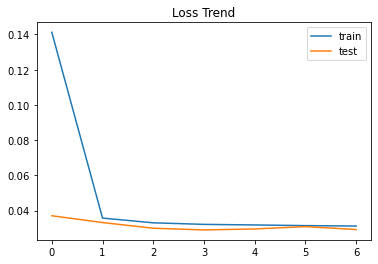

In [16]:
plt.title('Loss Trend')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

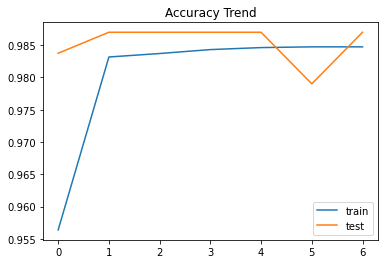

In [17]:
plt.title('Accuracy Trend')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [18]:
np.unique(data['Product'])

array(['Bank account or service', 'Consumer Loan', 'Credit card',
       'Credit reporting', 'Debt collection', 'Money transfers',
       'Mortgage', 'Other financial service', 'Payday loan',
       'Prepaid card', 'Student loan', 'Virtual currency'], dtype=object)

In [20]:
new_complaint = ['Incorrect information on credit report']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Bank account or service', 'Consumer Loan', 'Credit card',
       'Credit reporting', 'Debt collection', 'Money transfers',
       'Mortgage', 'Other financial service', 'Payday loan',
       'Prepaid card', 'Student loan', 'Virtual currency']
print(labels[np.argmax(pred)])

Credit reporting
